In [2]:
import pandas as pd
data=pd.read_csv('merged_data.csv')

KeyboardInterrupt: 

In [ ]:
data = data.sample(frac=0.5, random_state=62)

In [ ]:
data.drop(['create_dt','start_time','end_time','name'])

/Users/raj/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


--- Basic Exploration of Telemetry Train ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516073 entries, 0 to 516072
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   create_dt          516073 non-null  object 
 1   mdm_object_name    516073 non-null  int64  
 2   mdm_model_id       516073 non-null  int64  
 3   lon                516073 non-null  float64
 4   lat                516073 non-null  float64
 5   alt                516073 non-null  int64  
 6   speed_gps          516073 non-null  float64
 7   direction          516073 non-null  float64
 8   accel_forward_nn   516073 non-null  float64
 9   accel_braking_nn   516073 non-null  float64
 10  accel_angular_nn   516073 non-null  float64
 11  accel_vertical_nn  516073 non-null  float64
dtypes: float64(8), int64(3), object(1)
memory usage: 47.2+ MB
None
       mdm_object_name   mdm_model_id           lon           lat  \
count    516073.00000

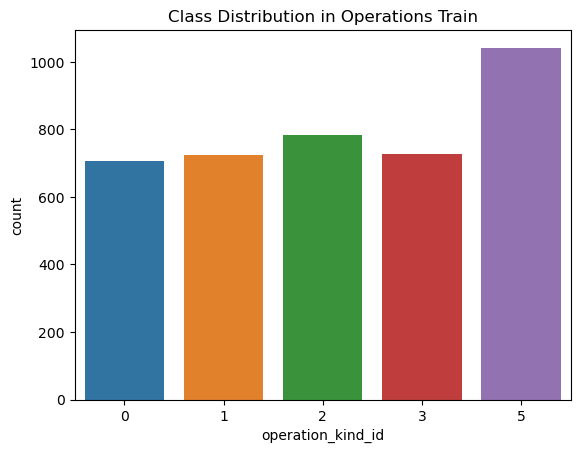

Exploration and feature engineering complete. Processed data saved.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets

telemetry_train = pd.read_csv('./dataset/telemetry_for_operations_training.csv')
telemetry_val = pd.read_csv('./dataset/telemetry_for_operations_validation.csv')
operations_train = pd.read_csv('./dataset/operations_labels_training.csv')

# Basic Data Exploration
def basic_exploration(df, df_name):
    print(f"--- Basic Exploration of {df_name} ---")
    print(df.info())  # Data types and non-null counts
    print(df.describe())  # Statistical overview of numerical columns
    print("\nMissing values per column:")
    print(df.isnull().sum())  # Missing values
    print("\n")

# Run exploration for telemetry and operations datasets
basic_exploration(telemetry_train, 'Telemetry Train')
basic_exploration(operations_train, 'Operations Train')

# Check class distribution (for 'operation_kind_id')
def class_distribution(df, target_column, df_name):
    print(f"--- Class Distribution in {df_name} ---")
    print(df[target_column].value_counts())
    sns.countplot(x=target_column, data=df)
    plt.title(f"Class Distribution in {df_name}")
    plt.show()

class_distribution(operations_train, 'operation_kind_id', 'Operations Train')

# Feature Engineering example (You can expand this part)
# Creating a 'speed_change' feature by calculating speed differences
telemetry_train['speed_change'] = telemetry_train['speed_gps'].diff()

# Optional: Calculate distance from lat/long using Haversine formula (you can skip if irrelevant)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

# Calculating distance between consecutive rows
telemetry_train['distance'] = haversine(telemetry_train['lat'].shift(), telemetry_train['lon'].shift(),
                                        telemetry_train['lat'], telemetry_train['lon'])

# Saving processed data to CSV for sharing with me
telemetry_train.to_csv('processed_telemetry_train.csv', index=False)
operations_train.to_csv('processed_operations_train.csv', index=False)

print("Exploration and feature engineering complete. Processed data saved.")


In [2]:
# Required imports
import pandas as pd
import numpy as np
from datetime import datetime

# Assuming telemetry_train and operations_train are the datasets
# Convert to datetime for both telemetry and operations datasets
telemetry_train['create_dt'] = pd.to_datetime(telemetry_train['create_dt'], errors='coerce', format='%Y-%m-%d %H:%M:%S')
operations_train['start_time'] = pd.to_datetime(operations_train['start_time'], errors='coerce', format='%Y-%m-%d %H:%M:%S')
operations_train['end_time'] = pd.to_datetime(operations_train['end_time'], errors='coerce', format='%Y-%m-%d %H:%M:%S')

# Initialize a column for the operation kind in telemetry data
telemetry_train['operation_kind_id'] = np.nan

# Function to assign operation_kind_id based on time intervals
def assign_operation_kind(telemetry_df, operations_df):
    for idx, op in operations_df.iterrows():
        # Create a mask to select telemetry points within the operation's time range
        mask = (telemetry_df['create_dt'] >= op['start_time']) & (telemetry_df['create_dt'] <= op['end_time'])
        telemetry_df.loc[mask, 'operation_kind_id'] = op['operation_kind_id']

    return telemetry_df

# Apply the function to assign operation kind to telemetry data
telemetry_train = assign_operation_kind(telemetry_train, operations_train)

# Drop any telemetry rows without an operation_kind_id
telemetry_train = telemetry_train.dropna(subset=['operation_kind_id'])

# Convert operation_kind_id back to integer after merge
telemetry_train['operation_kind_id'] = telemetry_train['operation_kind_id'].astype(int)

# Save the merged and processed telemetry data
telemetry_train.to_csv('merged_telemetry_train.csv', index=False)

print("Merged telemetry with operation states and saved to 'merged_telemetry_train.csv'.")


Merged telemetry with operation states and saved to 'merged_telemetry_train.csv'.


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Load the merged dataset
data = pd.read_csv('merged_telemetry_train.csv')

# Check the first few rows to understand the structure
print(data.head())


             create_dt  mdm_object_name  mdm_model_id       lon       lat  \
0  2023-09-29 08:12:46             1498            62 -0.039352  0.005476   
1  2023-09-29 08:12:47             1498            62 -0.039367  0.005442   
2  2023-09-29 08:12:49             1498            62 -0.039382  0.005362   
3  2023-09-29 08:12:51             1498            62 -0.039397  0.005297   
4  2023-09-29 08:12:53             1498            62 -0.039413  0.005232   

   alt  speed_gps  direction  accel_forward_nn  accel_braking_nn  \
0  217       15.7      194.0             0.098             0.000   
1  216       14.4      196.0             0.000             0.294   
2  216       15.2      180.0             0.000             0.490   
3  216       12.9      198.0             0.000             0.196   
4  216       10.6      180.0             0.000             1.372   

   accel_angular_nn  accel_vertical_nn  speed_change  distance  \
0             0.490               0.98           NaN       NaN

Class Distribution of Operation Kinds:
operation_kind_id
2    233873
5    166704
0     67714
1     35413
3      7332
Name: count, dtype: int64


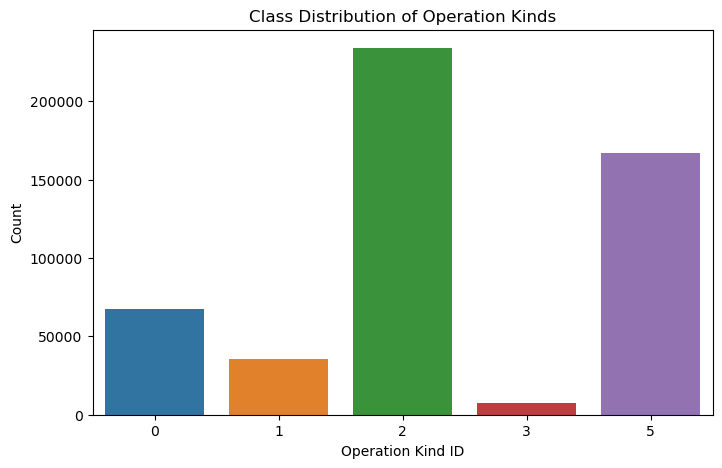

In [4]:
# Class distribution of 'operation_kind_id'
class_counts = data['operation_kind_id'].value_counts()

# Display class counts
print("Class Distribution of Operation Kinds:")
print(class_counts)

# Visualize the class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='operation_kind_id', data=data)
plt.title("Class Distribution of Operation Kinds")
plt.xlabel("Operation Kind ID")
plt.ylabel("Count")
plt.show()


In [5]:
# Summary statistics
print("Summary Statistics for Numerical Columns:")
print(data.describe())


Summary Statistics for Numerical Columns:
       mdm_object_name   mdm_model_id           lon           lat  \
count    511036.000000  511036.000000  5.110360e+05  5.110360e+05   
mean        705.104265      61.462817 -5.851691e+02 -5.851146e+02   
std         636.689950       0.498616  2.418493e+04  2.418268e+04   
min         119.000000      61.000000 -1.000142e+06 -1.000049e+06   
25%         121.000000      61.000000 -2.184970e-02 -9.759851e-03   
50%         125.000000      61.000000  7.630285e-03  2.370887e-03   
75%        1436.000000      62.000000  2.122587e-02  9.058051e-03   
max        1498.000000      62.000000  3.247159e-02  2.044874e-02   

                 alt      speed_gps      direction  accel_forward_nn  \
count  511036.000000  511036.000000  511036.000000     511036.000000   
mean       42.289541      13.587556     176.658761          0.247118   
std        94.400792      10.362618     102.916823          0.546103   
min      -146.000000       0.000000       0.0000

In [6]:
# Check for missing values
missing_values = data.isnull().sum()

# Display missing values
print("Missing Values Per Column:")
print(missing_values)


Missing Values Per Column:
create_dt            0
mdm_object_name      0
mdm_model_id         0
lon                  0
lat                  0
alt                  0
speed_gps            0
direction            0
accel_forward_nn     0
accel_braking_nn     0
accel_angular_nn     0
accel_vertical_nn    0
speed_change         1
distance             1
operation_kind_id    0
dtype: int64


## using XGBOOST

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Load your dataset
data = pd.read_csv('merged_telemetry_train.csv')

# Check unique classes in the target variable
print("Unique classes in operation_kind_id before processing:", data['operation_kind_id'].unique())

# Initialize the Label Encoder
label_encoder = LabelEncoder()

# Fit and transform the target variable
data['operation_kind_id'] = label_encoder.fit_transform(data['operation_kind_id'])

# Check unique classes after encoding
print("Unique classes in operation_kind_id after encoding:", data['operation_kind_id'].unique())

# Features and target variable
X = data.drop(columns=['operation_kind_id','create_dt'])  # Drop target column
y = data['operation_kind_id']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = XGBClassifier(
    n_estimators=200,           # Corresponding to nround
    max_depth=7,                # Corresponding to max_depth
    min_child_weight=10,
    subsample=0.7,              # Corresponding to subsample
    colsample_bytree=1,         # Corresponding to colsample_bytree
    colsample_bylevel=1,        # Corresponding to colsample_bylevel
    learning_rate=0.1,          # Corresponding to eta
    objective='multi:softprob', # Specifying the objective
    num_class=5,                # Corresponding to num_class
    gamma=0,                     # Corresponding to gamma
    reg_lambda=1,                # Corresponding to lambda
    reg_alpha=0,                 # Corresponding to alpha
    n_jobs=8,                   # Corresponding to nthread
    seed=1234,                  # Corresponding to seed
    tree_method='exact',        # Specified tree method
    eval_metric='mlogloss',     # Evaluation metric
    use_label_encoder=False       # Prevent warnings about label encoding
)
# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


In [8]:
import pandas as pd

# Load the validation dataset (ensure this path is correct)
telemetry_val = pd.read_csv('./dataset/telemetry_for_operations_validation.csv')

# Convert create_dt column to datetime (if applicable)
# telemetry_val['create_dt'] = pd.to_datetime(telemetry_val['create_dt'], errors='coerce', format='%Y-%m-%d')

# Check for missing columns
required_columns = ['mdm_object_name', 'mdm_model_id', 'lon', 'lat', 'alt', 
                    'speed_gps', 'direction', 'accel_forward_nn', 
                    'accel_braking_nn', 'accel_angular_nn', 
                    'accel_vertical_nn', 'speed_change', 'distance']

# Add the missing columns with default values (e.g., zeros)
for col in required_columns:
    if col not in telemetry_val.columns:
        telemetry_val[col] = 0.0  # Set default value, adjust if necessary

# Now you should have all required columns
print(telemetry_val.info())  # Verify the columns

# Prepare features for the model (drop create_dt and operation_kind_id)
X_valid = telemetry_val.drop(columns=['create_dt', 'operation_kind_id'], errors='ignore')

# If you applied any encoding to categorical variables in training, do the same here
# For example:
# X_valid = pd.get_dummies(X_valid, columns=['mdm_model_id'], drop_first=True)

# Scale the features if needed (make sure to use the same scaler)
#X_valid_scaled = scaler.transform(X_valid)  # Use the scaler fitted on training data

# Make predictions using the trained model
predictions = model.predict(X_valid)  # Directly predict class labels

# If you used label encoding during training, decode the labels here
predictions = label_encoder.inverse_transform(predictions)  # Map predicted indices back to labels

# Create the submission DataFrame
submission = pd.DataFrame({
    'create_dt': telemetry_val['create_dt'],  # Include this column if needed
    'mdm_object_name': telemetry_val['mdm_object_name'],
    'operation_kind_id': predictions
})

# Set the index as required
submission.set_index(['create_dt', 'mdm_object_name'], inplace=True)

# Ensure the shape is (expected_number_of_rows, 3)
submission = submission.reset_index()  # Reset index to maintain 3 columns

# Save the submission file
submission.to_csv('submission.csv', index=False)  # Save without index

# Optionally, display the first few rows of the submission
print(submission.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260111 entries, 0 to 260110
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   create_dt          260111 non-null  object 
 1   mdm_object_name    260111 non-null  int64  
 2   mdm_model_id       260111 non-null  int64  
 3   lon                260111 non-null  float64
 4   lat                260111 non-null  float64
 5   alt                260111 non-null  int64  
 6   speed_gps          260111 non-null  float64
 7   direction          260111 non-null  float64
 8   accel_forward_nn   260111 non-null  float64
 9   accel_braking_nn   260111 non-null  float64
 10  accel_angular_nn   260111 non-null  float64
 11  accel_vertical_nn  260111 non-null  float64
 12  speed_change       260111 non-null  float64
 13  distance           260111 non-null  float64
dtypes: float64(10), int64(3), object(1)
memory usage: 27.8+ MB
None
             create_dt  mdm_object_n

In [9]:
import joblib
from xgboost import XGBClassifier

# Assuming you have trained your model

# Save the model
joblib.dump(model, 'xgb_classifier_model.joblib')

# To load the model later
loaded_model = joblib.load('xgb_classifier_model.joblib')


# Nural netwroks

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Load your dataset
data = pd.read_csv('merged_telemetry_train.csv')

# Prepare features and labels
X = data.drop(columns=['operation_kind_id', 'create_dt'])
y = data['operation_kind_id']

# Encode the target variable if necessary
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [32]:
# Build the neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Output layer for multi-class classification

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



C:\Users\aravi\GEN\ai\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Path to save the model
    monitor='val_loss',  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode='min',  # 'min' because we want to minimize the validation loss
    verbose=1  # Verbosity mode
)

# Add EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



In [ ]:
# Train the model with checkpoints
history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), 
                    epochs=10, batch_size=32, 
                    callbacks=[checkpoint, early_stopping])


Epoch 1/10
12765/12776 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5925 - loss: 1.0013
Epoch 1: val_loss improved from inf to 1.23562, saving model to best_model.keras
12776/12776 ━━━━━━━━━━━━━━━━━━━━ 35s 3ms/step - accuracy: 0.5925 - loss: 1.0014 - val_accuracy: 0.4582 - val_loss: 1.2356
Epoch 2/10
12770/12776 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4586 - loss: 1.2373
Epoch 2: val_loss improved from 1.23562 to 1.23504, saving model to best_model.keras
12776/12776 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.4586 - loss: 1.2373 - val_accuracy: 0.4582 - val_loss: 1.2350
Epoch 3/10


In [ ]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

# Make predictions
predictions = model.predict(X_val_scaled)
predicted_classes = predictions.argmax(axis=1)

# Map back to original class labels if necessary
predicted_labels = label_encoder.inverse_transform(predicted_classes)